In [382]:
import json
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing import sequence
from keras.models import Sequential, Input, Model
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers.embeddings import Embedding


In [414]:
from sklearn import metrics as mt
from matplotlib import pyplot as plt
from skimage.io import imshow
import seaborn as sns
%matplotlib inline

def summarize_net(net, X_test, y_test, title_text=''):
    plt.figure(figsize=(15,5))
    yhat = np.argmax(net.predict(X_test), axis=1)
    acc = mt.accuracy_score(y_test,yhat)
    cm = mt.confusion_matrix(y_test,yhat)
    cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
    sns.heatmap(cm, annot=True, fmt='.2f')
    plt.title(title_text+'{:.4f}'.format(acc))
    

In [415]:
#create custom f1 metric from custom recall and precision
from keras.layers import concatenate
from keras import backend as K

def recall_m(y_true, y_pred): # recall is true positive / (total actual positive)
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) # y_true * y_pred will only give 1 for true positives
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1))) # actual positives are just y_true
        # recall is true positive / (total actual positive).. the episol is a small number to prevent divide by zero errors
        recall = true_positives / (possible_positives + K.epsilon()) 
        return recall

def precision_m(y_true, y_pred): #precision is true positives / (total predicted positives)
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) # y_true * y_pred will only give 1 for true positives
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1))) # predicted positives
        # (true positive / predicted positive).. the episol is a small number to prevent divide by zero errors
        precision = true_positives / (predicted_positives + K.epsilon())   
        return precision

def f1_m(y_true, y_pred): # f1 = 2 * (precision*recall / precision + recall)
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon())) 

In [351]:
tweets = []
article_link = []
headline=[]
y = []
tokenizer = Tokenizer(num_words=NUM_TOP_WORDS)
for line in open('C:/Users/sulem/OneDrive/Desktop/machin learnign/project7/Sarcasm_Headlines_Dataset.json', 'r'):
    tweets.append(json.loads(line))
    article_link.append(tweets[len(tweets)-1]['article_link'])
    headline.append(tweets[len(tweets)-1]['headline'])
    y.append(tweets[len(tweets)-1]['is_sarcastic'])

In [352]:
NUM_TOP_WORDS = None
tokenizer = Tokenizer(num_words=NUM_TOP_WORDS)
tokenizer.fit_on_texts(headline)
sequences = tokenizer.texts_to_sequences(headline)

In [362]:
MAX_ART_LEN = 500 # maximum and minimum number of words
word_index = tokenizer.word_index
NUM_TOP_WORDS = len(word_index) if NUM_TOP_WORDS==None else NUM_TOP_WORDS
top_words = min((len(word_index),NUM_TOP_WORDS))
print('Found %s unique tokens. Distilled to %d top words.' % (len(word_index),top_words))


Found 29656 unique tokens. Distilled to 29656 top words.


In [363]:
X = pad_sequences(sequences, maxlen=MAX_ART_LEN)

In [444]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, ShuffleSplit
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
sss=StratifiedShuffleSplit(n_splits=3, random_state=7,train_size = .8,test_size = .2,)
# Split it into train / test subsets

#X_train, X_test, y_train_ohe, y_test_ohe = train_test_split(X, y_ohe, test_size=0.2,
#                                                            stratify=y, 
#                                                            random_state=42)

In [376]:
import numpy as np
NUM_CLASSES = 2
print(X_train.shape,y_train_ohe.shape)
print(np.sum(y_train_ohe,axis=0))

(21367, 500) (21367, 2)
[11988.  9379.]


In [445]:

EMBED_SIZE = 50
rnns = []
input_holder = Input(shape=(X_train.shape[1], ))

input_embed = Embedding(len(word_index) + 1, # input dimension (max int of OHE)
                EMBED_SIZE, # output dimension size
                input_length=MAX_ART_LEN)(input_holder) # number of words in each sequence


x = SimpleRNN(50,dropout=0.2, recurrent_dropout=0.2)(input_embed)
x = Dense(NUM_CLASSES, activation='sigmoid')(x)
rnn=Model(inputs=input_holder,outputs=x)
rnn.compile(loss='binary_crossentropy', 
              optimizer='rmsprop', 
              metrics=['acc', f1_m])
print(rnn.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 500)               0         
_________________________________________________________________
embedding_19 (Embedding)     (None, 500, 50)           1482850   
_________________________________________________________________
simple_rnn_16 (SimpleRNN)    (None, 50)                5050      
_________________________________________________________________
dense_18 (Dense)             (None, 2)                 102       
Total params: 1,488,002
Trainable params: 1,488,002
Non-trainable params: 0
_________________________________________________________________
None


In [446]:
history1=[]
for train_index, test_index in sss.split(X, y_ohe):
 input_embed = Embedding(len(word_index) + 1, # input dimension (max int of OHE)
                EMBED_SIZE, # output dimension size
                input_length=MAX_ART_LEN)(input_holder) # number of words in each sequence


 x = SimpleRNN(50,dropout=0.2, recurrent_dropout=0.2)(input_embed)
 x = Dense(NUM_CLASSES, activation='sigmoid')(x)
 print("TRAIN:", train_index.shape, "TEST:", test_index.shape)
 rnn=Model(inputs=input_holder,outputs=x)
 rnn.compile(loss='binary_crossentropy', 
              optimizer='rmsprop', 
              metrics=['acc', f1_m])
 X_train, X_test = X[train_index], X[test_index]
 y_train_ohe, y_test_ohe = y_ohe[train_index], y_ohe[test_index]   
 history1.append(rnn.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe), epochs=5, batch_size=64))

TRAIN: (21367,) TEST: (5342,)
Train on 21367 samples, validate on 5342 samples
Epoch 1/5
21367/21367 [==============================] - 77s 4ms/step - loss: 0.6956 - acc: 0.5381 - f1_m: 0.5349 - val_loss: 0.6653 - val_acc: 0.5663 - val_f1_m: 0.5671
Epoch 2/5
21367/21367 [==============================] - 61s 3ms/step - loss: 0.6366 - acc: 0.6342 - f1_m: 0.6354 - val_loss: 0.5585 - val_acc: 0.7228 - val_f1_m: 0.7220
Epoch 3/5
21367/21367 [==============================] - 59s 3ms/step - loss: 0.5203 - acc: 0.7429 - f1_m: 0.7433 - val_loss: 0.4777 - val_acc: 0.7714 - val_f1_m: 0.7724
Epoch 4/5
21367/21367 [==============================] - 58s 3ms/step - loss: 0.4228 - acc: 0.8083 - f1_m: 0.8086 - val_loss: 0.4131 - val_acc: 0.8154 - val_f1_m: 0.8153
Epoch 5/5
21367/21367 [==============================] - 59s 3ms/step - loss: 0.3515 - acc: 0.8512 - f1_m: 0.8512 - val_loss: 0.3802 - val_acc: 0.8402 - val_f1_m: 0.8405
TRAIN: (21367,) TEST: (5342,)
Train on 21367 samples, validate on 5342 

In [471]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
history2=[]
for train_index, test_index in sss.split(X, y_ohe):
 input_embed = Embedding(len(word_index) + 1, # input dimension (max int of OHE)
                EMBED_SIZE, # output dimension size
                input_length=MAX_ART_LEN) # number of words in each sequence
 rnnls = Sequential()
 rnnls.add(input_embed)
 rnnls.add(LSTM(50,dropout=0.2, recurrent_dropout=0.2))
 rnnls.add(Dense(NUM_CLASSES, activation='sigmoid'))
 rnnls.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=['accuracy'])
 print("TRAIN:", train_index.shape, "TEST:", test_index.shape)
 X_train, X_test = X[train_index], X[test_index]
 y_train_ohe, y_test_ohe = y_ohe[train_index], y_ohe[test_index]
 rnnls.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=['acc', f1_m])
 history2.append(rnnls.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe), epochs=5, batch_size=64))
print(rnnls.summary())

TRAIN: (21367,) TEST: (5342,)
Train on 21367 samples, validate on 5342 samples
Epoch 1/5
21367/21367 [==============================] - 156s 7ms/step - loss: 0.5012 - acc: 0.7568 - f1_m: 0.7501 - val_loss: 0.3412 - val_acc: 0.8532 - val_f1_m: 0.8482
Epoch 2/5
21367/21367 [==============================] - 154s 7ms/step - loss: 0.3134 - acc: 0.8705 - f1_m: 0.8668 - val_loss: 0.3190 - val_acc: 0.8618 - val_f1_m: 0.8603
Epoch 3/5
21367/21367 [==============================] - 153s 7ms/step - loss: 0.2580 - acc: 0.8984 - f1_m: 0.8973 - val_loss: 0.3121 - val_acc: 0.8677 - val_f1_m: 0.8640
Epoch 4/5
21367/21367 [==============================] - 152s 7ms/step - loss: 0.2106 - acc: 0.9168 - f1_m: 0.9156 - val_loss: 0.3146 - val_acc: 0.8695 - val_f1_m: 0.8678
Epoch 5/5
21367/21367 [==============================] - 150s 7ms/step - loss: 0.2071 - acc: 0.9237 - f1_m: 0.9232 - val_loss: 0.3179 - val_acc: 0.8714 - val_f1_m: 0.8685
TRAIN: (21367,) TEST: (5342,)
Train on 21367 samples, validate on 

In [472]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
history3=[]
for train_index, test_index in sss.split(X, y_ohe):
 input_embed = Embedding(len(word_index) + 1, # input dimension (max int of OHE)
                EMBED_SIZE, # output dimension size
                input_length=MAX_ART_LEN) # number of words in each sequence
 rnngd = Sequential()
 rnngd.add(input_embed)
 rnngd.add(GRU(50,dropout=0.2, recurrent_dropout=0.2))
 rnngd.add(Dense(NUM_CLASSES, activation='sigmoid'))
 rnngd.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=['accuracy'])
 print("TRAIN:", train_index.shape, "TEST:", test_index.shape)
 X_train, X_test = X[train_index], X[test_index]
 y_train_ohe, y_test_ohe = y_ohe[train_index], y_ohe[test_index]
 rnngd.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=['acc', f1_m])
 history3.append(rnngd.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe), epochs=5, batch_size=64))
print(rnngd.summary())

TRAIN: (21367,) TEST: (5342,)
Train on 21367 samples, validate on 5342 samples
Epoch 1/5
21367/21367 [==============================] - 159s 7ms/step - loss: 0.4816 - acc: 0.7611 - f1_m: 0.7567 - val_loss: 0.3382 - val_acc: 0.8510 - val_f1_m: 0.8485
Epoch 2/5
21367/21367 [==============================] - 144s 7ms/step - loss: 0.2967 - acc: 0.8782 - f1_m: 0.8767 - val_loss: 0.3207 - val_acc: 0.8613 - val_f1_m: 0.8590
Epoch 3/5
21367/21367 [==============================] - 144s 7ms/step - loss: 0.2388 - acc: 0.9047 - f1_m: 0.9024 - val_loss: 0.3115 - val_acc: 0.8656 - val_f1_m: 0.8626
Epoch 4/5
21367/21367 [==============================] - 156s 7ms/step - loss: 0.2029 - acc: 0.9191 - f1_m: 0.9189 - val_loss: 0.3095 - val_acc: 0.8675 - val_f1_m: 0.8682
Epoch 5/5
21367/21367 [==============================] - 161s 8ms/step - loss: 0.1873 - acc: 0.9276 - f1_m: 0.9275 - val_loss: 0.3102 - val_acc: 0.8701 - val_f1_m: 0.8680
TRAIN: (21367,) TEST: (5342,)
Train on 21367 samples, validate on 

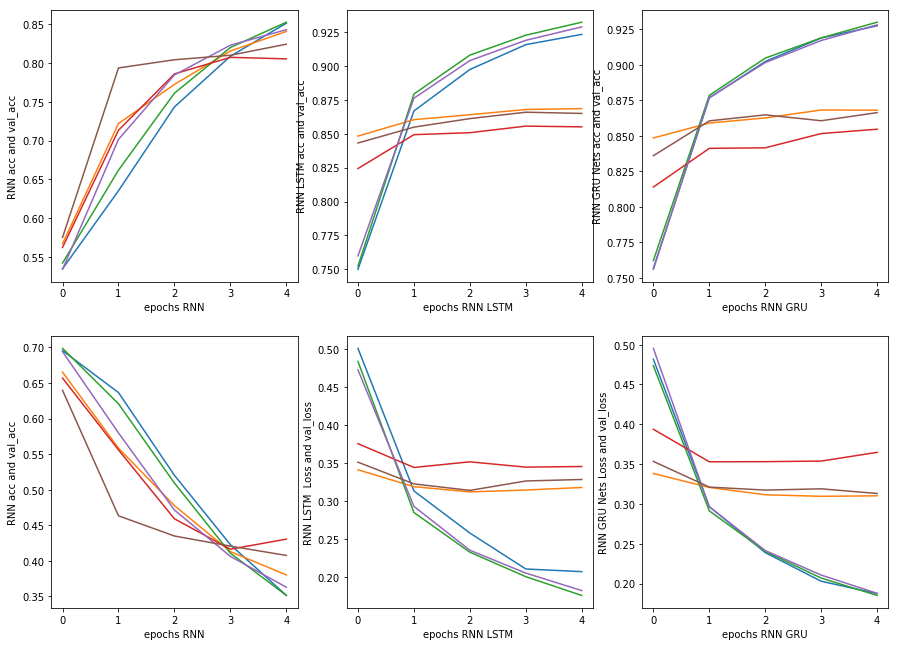

In [473]:
plt.figure(figsize=(15,11))
plt.subplot(2,3,1)
plt.ylabel('RNN acc and val_acc')
plt.xlabel('epochs RNN')
plt.plot(history1[0].history['f1_m'])

plt.plot(history1[0].history['val_f1_m'])
plt.plot(history1[1].history['f1_m'])

plt.plot(history1[1].history['val_f1_m'])
plt.plot(history1[2].history['f1_m'])

plt.plot(history1[2].history['val_f1_m'])
plt.subplot(2,3,4)
plt.ylabel('RNN acc and val_acc')
plt.plot(history1[0].history['loss'])
plt.xlabel('epochs RNN')
plt.plot(history1[0].history['val_loss'])

plt.plot(history1[1].history['loss'])
plt.plot(history1[1].history['val_loss'])
plt.plot(history1[2].history['loss'])
plt.plot(history1[2].history['val_loss']) 
         
plt.subplot(2,3,2)
plt.ylabel('RNN LSTM acc and val_acc')
plt.xlabel('epochs RNN LSTM ')
plt.plot(history2[0].history['f1_m'])
plt.plot(history2[0].history['val_f1_m'])
plt.plot(history2[1].history['f1_m'])
plt.plot(history2[1].history['val_f1_m'])
plt.plot(history2[2].history['f1_m'])
plt.plot(history2[2].history['val_f1_m'])
plt.subplot(2,3,5)
plt.plot(history2[0].history['loss'])
plt.ylabel('RNN LSTM  Loss and val_loss')
plt.plot(history2[0].history['val_loss'])
plt.xlabel('epochs RNN LSTM ')
plt.plot(history2[1].history['loss'])
plt.plot(history2[1].history['val_loss'])
plt.plot(history2[2].history['loss'])
plt.plot(history2[2].history['val_loss'])
plt.subplot(2,3,3)
plt.ylabel('RNN GRU Nets acc and val_acc')
plt.xlabel('epochs RNN GRU')
plt.plot(history3[0].history['f1_m'])
plt.plot(history3[0].history['val_f1_m'])
plt.plot(history3[1].history['f1_m'])
plt.plot(history3[1].history['val_f1_m'])
plt.plot(history3[2].history['f1_m'])
plt.plot(history3[2].history['val_f1_m'])
plt.subplot(2,3,6)
plt.plot(history3[0].history['loss'])
plt.ylabel('RNN GRU Nets Loss and val_loss')
plt.plot(history3[0].history['val_loss'])
plt.xlabel('epochs RNN GRU')
plt.plot(history3[1].history['loss'])
plt.plot(history3[1].history['val_loss'])
plt.plot(history3[2].history['loss'])
plt.plot(history3[2].history['val_loss'])




In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
history4=[]
for train_index, test_index in sss.split(X, y_ohe):
 input_embed = Embedding(len(word_index) + 1, # input dimension (max int of OHE)
                EMBED_SIZE, # output dimension size
                input_length=MAX_ART_LEN) # number of words in each sequence
 rnnls1 = Sequential()
 rnnls1.add(input_embed)
 rnnls1.add(LSTM(100,dropout=0.3,recurrent_dropout=0.3))
 rnnls1.add(Dense(NUM_CLASSES, activation='sigmoid'))
 rnnls1.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=['accuracy'])
 print("TRAIN:", train_index.shape, "TEST:", test_index.shape)
 X_train, X_test = X[train_index], X[test_index]
 y_train_ohe, y_test_ohe = y_ohe[train_index], y_ohe[test_index]
 rnnls1.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=['acc', f1_m])
 history4.append(rnnls1.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe), epochs=5, batch_size=64))
print(rnnls1.summary())

TRAIN: (21367,) TEST: (5342,)
Train on 21367 samples, validate on 5342 samples
Epoch 1/5
21367/21367 [==============================] - 210s 10ms/step - loss: 0.4748 - acc: 0.7674 - f1_m: 0.7575 - val_loss: 0.3446 - val_acc: 0.8491 - val_f1_m: 0.8474
Epoch 2/5
21367/21367 [==============================] - 192s 9ms/step - loss: 0.3679 - acc: 0.8627 - f1_m: 0.8596 - val_loss: 0.3448 - val_acc: 0.8572 - val_f1_m: 0.8546
Epoch 3/5
21367/21367 [==============================] - 192s 9ms/step - loss: 0.2629 - acc: 0.8952 - f1_m: 0.8939 - val_loss: 0.3163 - val_acc: 0.8677 - val_f1_m: 0.8651
Epoch 4/5
21367/21367 [==============================] - 184s 9ms/step - loss: 0.2184 - acc: 0.9143 - f1_m: 0.9137 - val_loss: 0.3127 - val_acc: 0.8680 - val_f1_m: 0.8678
Epoch 5/5
21367/21367 [==============================] - 186s 9ms/step - loss: 0.1907 - acc: 0.9249 - f1_m: 0.9240 - val_loss: 0.3188 - val_acc: 0.8714 - val_f1_m: 0.8711
TRAIN: (21367,) TEST: (5342,)
Train on 21367 samples, validate on

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
history4=[]
for train_index, test_index in sss.split(X, y_ohe):
 input_embed = Embedding(len(word_index) + 1, # input dimension (max int of OHE)
                EMBED_SIZE, # output dimension size
                input_length=MAX_ART_LEN) # number of words in each sequence
 rnnls1 = Sequential()
 rnnls1.add(input_embed)
 rnnls1.add(LSTM(100,return_sequences=True,dropout=0.2,recurrent_dropout=0.2))
 rnnls1.add(LSTM(100,dropout=0.3,recurrent_dropout=0.3))   
 rnnls1.add(Dense(NUM_CLASSES, activation='sigmoid'))
 rnnls1.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=['accuracy'])
 print("TRAIN:", train_index.shape, "TEST:", test_index.shape)
 X_train, X_test = X[train_index], X[test_index]
 y_train_ohe, y_test_ohe = y_ohe[train_index], y_ohe[test_index]
 rnnls1.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=['acc', f1_m])
 history4.append(rnnls1.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe), epochs=5, batch_size=64))
print(rnnls1.summary())

In [ ]:
import numpy as np
from mlxtend.evaluate import mcnemar_table
tb = mcnemar_table(y_target=y_target, 
                   y_model1=y_model1, 
                   y_model2=y_model2)

print(tb)